In [1]:
%load_ext autoreload
%autoreload 3
import sys

sys.path.append("..")
from nnsight import LanguageModel, CONFIG
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch as th
import torch  # for those who are afraid of th
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from pathlib import Path
from time import time
import itertools
from dataclasses import dataclass
from warnings import warn
from random import shuffle, sample
# Fix logger bug
import os
import babelnet
from nnsight import logger

logger.disabled = True
th.set_grad_enabled(False)
CONFIG.set_default_api_key(os.environ["NNSIGHT_API_KEY"])

import os

2024-06-18 15:26:08,498 [babelnet.conf] INFO: Using default configuration (no config file provided)
2024-06-18 15:26:08,506 [babelnet.api] INFO: BabelNet online RESTful API v1.2.0


## Get the prompts

In [4]:
batch_size = 16
from exp_tools import load_model
model_name = "meta-llama/Meta-Llama-3-70B" # "meta-llama/Meta-Llama-3-8B"
# model = load_model("/dlabscratch1/public/llm_weights/llama2_hf/Llama-2-7b-hf") #, dispatch=True)
model = load_model(model_name)
from translation_tools import prompts_from_df, get_bn_dataset

de_df = get_bn_dataset("de", "de")
de_prompts = prompts_from_df("de", "de", de_df)
fr_df = get_bn_dataset("fr", "fr")
fr_prompts = prompts_from_df("fr", "fr", fr_df)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# partial_ja = '''冷蔵庫 (シルバー)
# トラ (オレンジ)
# ブルーベリー (青)
# カボチャ'''
partial_ja = '''冷蔵庫 "シルバー"
トラ "オレンジ"
ブルーベリー "青"
カボチャ'''
# pumpkin_ja = partial_ja + ' ('
pumpkin_ja = partial_ja + ' "'
# partial_en = '''fridge (silver)
# tiger (orange)
# blueberry (blue)
# pumpkin'''
# pumpkin_en = partial_en + ' ('
partial_en = '''fridge "silver"
tiger "orange"
blueberry "blue"
pumpkin'''
pumpkin_en = partial_en + ' "'
from exp_tools import logit_lens_llama as llens
from utils import plot_topk_tokens
probs = llens(model, [pumpkin_en, pumpkin_ja, partial_en, partial_ja], remote=True)

66718b2b66a7e0efc8eef011 - RECEIVED: Your job has been received and is waiting approval.
66718b2b66a7e0efc8eef011 - APPROVED: Your job was approved and is waiting to be run.
66718b2b66a7e0efc8eef011 - COMPLETED: Your job has been completed.


In [6]:
from exp_tools import Prompt
colors = {
    "green" : "green",
    "orange" : "orange",
    "yellow" : "yellow",
    "green^JA" : ["緑", "グリーン", "みどり"],
    "orange^JA" : "オレンジ",
    "yellow^JA" : ["黄色", "イエロー"]
}
prompt = Prompt.from_strings(pumpkin_en, [], colors, model)
en_probs = prompt.get_latent_probs(probs[:1], layer=-1)
ja_probs = prompt.get_latent_probs(probs[1:2], layer=-1)
display(en_probs)
display(ja_probs)

{'green': tensor([0.0140]),
 'orange': tensor([0.8223]),
 'yellow': tensor([0.0634]),
 'green^JA': tensor([4.6253e-08]),
 'orange^JA': tensor([2.8213e-08]),
 'yellow^JA': tensor([8.5289e-07])}

{'green': tensor([2.4048e-05]),
 'orange': tensor([0.0003]),
 'yellow': tensor([8.2787e-05]),
 'green^JA': tensor([0.0347]),
 'orange^JA': tensor([0.6345]),
 'yellow^JA': tensor([0.1283])}

In [19]:
from exp_tools import Prompt
colors = {
    "green" : "green",
    "orange" : "orange",
    "yellow" : "yellow",
    "green^JA" : ["緑", "グリーン", "みどり"],
    "orange^JA" : "オレンジ",
    "yellow^JA" : ["黄色", "イエロー"]
}
prompt = Prompt.from_strings(pumpkin_en, [], colors, model)
en_probs = prompt.get_latent_probs(probs[:1], layer=-1)
ja_probs = prompt.get_latent_probs(probs[1:2], layer=-1)
display(en_probs)
display(ja_probs)

{'green': tensor([0.0393]),
 'orange': tensor([0.4381]),
 'yellow': tensor([0.3338]),
 'green^JA': tensor([1.6056e-07]),
 'orange^JA': tensor([2.9137e-07]),
 'yellow^JA': tensor([4.5349e-07])}

{'green': tensor([0.0004]),
 'orange': tensor([0.0003]),
 'yellow': tensor([0.0009]),
 'green^JA': tensor([0.1684]),
 'orange^JA': tensor([0.1587]),
 'yellow^JA': tensor([0.3051])}

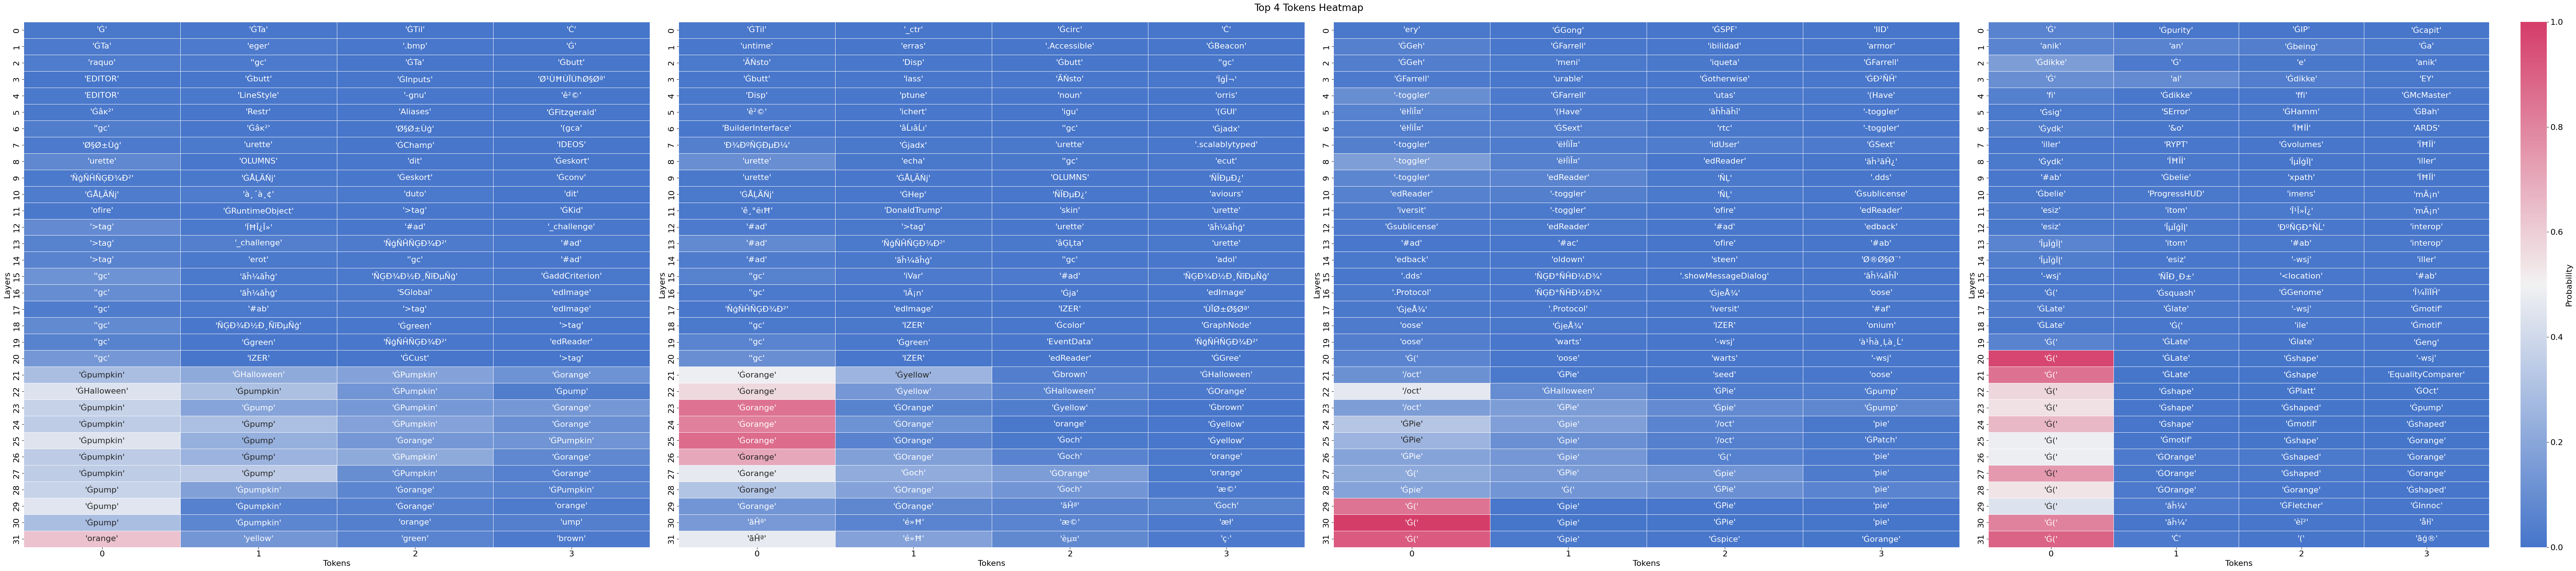

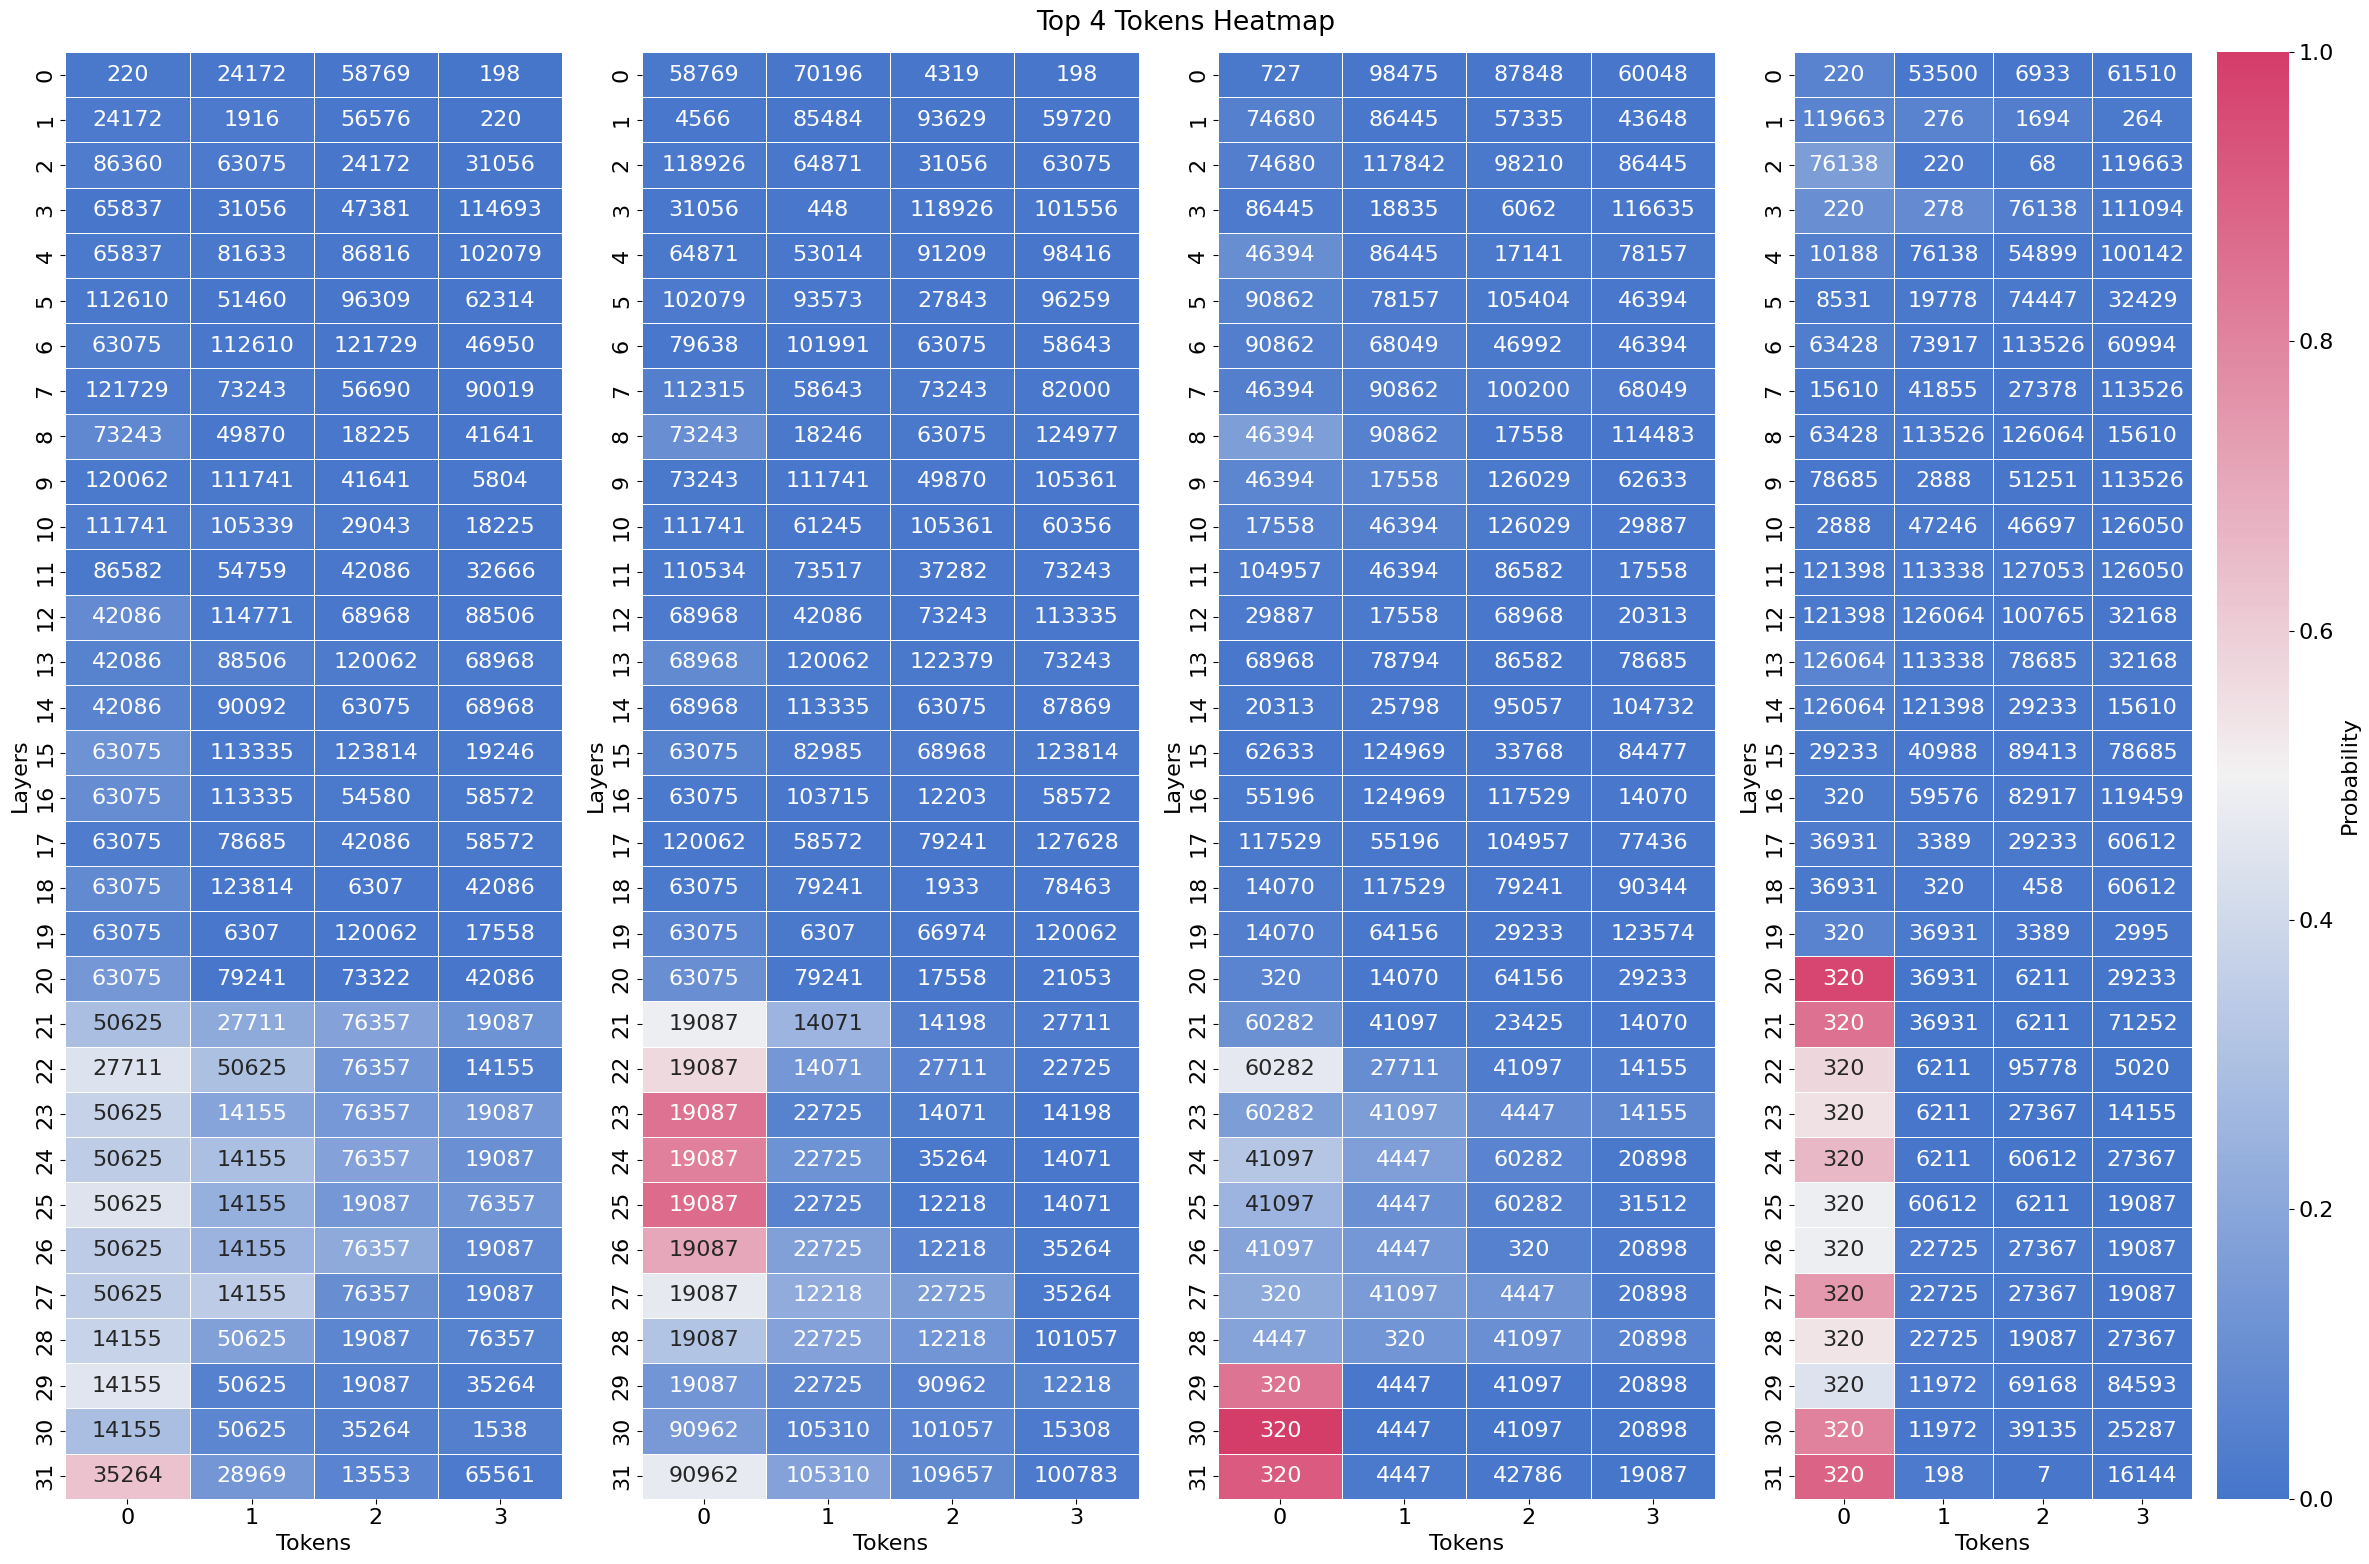

In [6]:
plot_topk_tokens(probs, model)
plot_topk_tokens(probs, model, use_token_ids=True)

In [3]:
model.tokenizer.decode(31491), model.tokenizer.decode(31682), model.tokenizer.decode(30514)

('黄', '赤', 'オ')

In [12]:
print(model.tokenizer.encode("黄"), model.tokenizer.encode("緑"))


[1, 31491] [1, 234, 186, 148]


In [7]:
with model.generate(pumpkin_ja, max_new_tokens=5, do_sample=False, remote=True):
    out = model.generator.output.save()
out
# from exp_tools import Prompt
# y_ja = "黄"
# g_ja = 


Setting `pad_token_id` to `eos_token_id`:FakeTensor(..., device='meta', size=(), dtype=torch.int64) for open-end generation.
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='meta', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, it may even crash.


66717a072ebc7796b9278da1 - RECEIVED: Your job has been received and is waiting approval.
66717a072ebc7796b9278da1 - APPROVED: Your job was approved and is waiting to be run.
66717a072ebc7796b9278da1 - COMPLETED: Your job has been completed.


tensor([[128000, 106142, 119154, 107086,    320,  57207,  33710, 110590,    340,
          20251,  32131,    320,  90962, 111999,  76428,    340, 112193,  25005,
            247, 102540,    320, 103271,    340,  71493, 103672, 109933,    320,
          90962, 111999,  76428,    340,  20251]])

In [8]:
model.tokenizer.decode(out[0])

'<|begin_of_text|>冷蔵庫 (シルバー)\nトラ (オレンジ)\nブルーベリー (青)\nカボチャ (オレンジ)\nト'

In [3]:
print(de_prompts[0])

Deutsch: "Zeit" - Deutsch: "Zeit"
Deutsch: "Fluss" - Deutsch: "Fluss"
Deutsch: "Norden" - Deutsch: "Norden"
Deutsch: "Turm" - Deutsch: "Turm"
Deutsch: "Holz" - Deutsch: "Holz"
Deutsch: "Buch" - Deutsch: "


## Compute the mean vector

In [4]:
from exp_tools import get_mean_activations
de_means = get_mean_activations(model, de_prompts, batch_size=batch_size)

  0%|          | 0/6 [00:00<?, ?it/s]

2024-06-10 16:02:44,312 [accelerate.utils.modeling] INFO: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [5]:
langs = ["fr", "es", "de", "it", "zh", "ru", "ja", "en"]
# all_df = get_bn_dataset("en", langs)

In [6]:
lang_means = []
for lang in langs:
    if lang == "de":
        continue
    lang_df = get_bn_dataset(lang, lang)
    lang_prompts = prompts_from_df(lang, lang, lang_df)
    lang_means.append(get_mean_activations(model, lang_prompts, batch_size=batch_size))
means = []
for i in range(len(lang_means[0])):
    mean = sum([m[i] for m in lang_means]) / len(lang_means)
    means.append(mean)
lang_means = means

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
steering_vectors = [neutral - de for de, neutral in zip(de_means, lang_means)]

In [8]:
from exp_tools import collect_activations
buch_prompt = '"'.join(de_prompts[0].split('"')[:-2])
print(buch_prompt)
buch_latents = collect_activations(model, de_prompts[0])

Deutsch: "Zeit" - Deutsch: "Zeit"
Deutsch: "Fluss" - Deutsch: "Fluss"
Deutsch: "Norden" - Deutsch: "Norden"
Deutsch: "Turm" - Deutsch: "Turm"
Deutsch: "Holz" - Deutsch: "Holz"
Deutsch: "Buch


In [9]:
neutral_buch = [buch + steering for buch, steering in zip(buch_latents, steering_vectors)]

In [10]:
description_prompt = """Nuage: Un nuage est en météorologie une masse visible constituée initialement d'une grande quantité de gouttelettes d'eau en suspension dans l'atmosphère au-dessus de la surface d'une planète.
Stern: Unter einem Stern versteht man in der Astronomie einen massereichen, selbstleuchtenden Himmelskörper aus sehr heißem Gas und Plasma, wie zum Beispiel die Sonne.
Car: A car is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one to eight people, have four tires, and mainly transport people rather than goods.
Montagne: Une montagne est une forme topographique de relief positif, à la surface de planètes telluriques, et faisant partie d'un ensemble — une chaîne de montagnes — ou formant un relief isolé.
Tiger: The tiger (Panthera tigris) is the largest extant cat species and a member of the genus Panthera. It is most recognisable for its dark vertical stripes on orange-brown fur with a lighter underside.
Wave: In physics, mathematics, and related fields, a wave is a propagating dynamic disturbance (change from equilibrium) of one or more quantities, sometimes as described by a wave equation.
Wasser: Wasser ist insbesondere die chemische Verbindung H2O, bestehend aus den Elementen Sauerstoff und Wasserstoff.
Maison: Une maison est un bâtiment d'habitation, souvent de taille moyenne destiné au logement d'une famille ou de plusieurs, sans être considéré comme un immeuble collectif.
?"""

In [11]:
from nnsight_utils import get_layer_output, get_next_token_probs
layer = 22
max_t = 20
with model.generate(description_prompt, max_new_tokens=max_t):
    get_layer_output(model, layer)[:, -1] = neutral_buch[layer]
    # probs = get_next_token_probs(model).save()
    gen = model.generator.output[0].cpu().save()
print(model.tokenizer.decode(gen))
with model.generate(description_prompt, max_new_tokens=max_t, do_sample=False):
    get_layer_output(model, layer)[:, -1] = buch_latents[layer]
    gen2 = model.generator.output[0].cpu().save()
print()
print(model.tokenizer.decode(gen2))
with model.generate(description_prompt, max_new_tokens=max_t):
    clean_gen = model.generator.output[0].cpu().save()
print()
print(model.tokenizer.decode(clean_gen))

`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='cuda:0', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, it may even crash.
/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:533: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:538: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='cuda:0', siz

<s>Nuage: Un nuage est en météorologie une masse visible constituée initialement d'une grande quantité de gouttelettes d'eau en suspension dans l'atmosphère au-dessus de la surface d'une planète.
Stern: Unter einem Stern versteht man in der Astronomie einen massereichen, selbstleuchtenden Himmelskörper aus sehr heißem Gas und Plasma, wie zum Beispiel die Sonne.
Car: A car is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one to eight people, have four tires, and mainly transport people rather than goods.
Montagne: Une montagne est une forme topographique de relief positif, à la surface de planètes telluriques, et faisant partie d'un ensemble — une chaîne de montagnes — ou formant un relief isolé.
Tiger: The tiger (Panthera tigris) is the largest extant cat species and a member of the genus Panthera. It is most recognisable for its dark vertical stripes on orange-brown fur with a lighter underside.
Wave: In physics, m

/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:533: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/dlabscratch1/cdumas/.conda_envs/llmenglish/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:538: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
`eos_token_id` should consist of positive integers, but is FakeTensor(..., device='cuda:0', size=(1,), dtype=torch.int64). Your generation will not stop until the maximum length is reached. Depending on other flags, it may even crash.



<s>Nuage: Un nuage est en météorologie une masse visible constituée initialement d'une grande quantité de gouttelettes d'eau en suspension dans l'atmosphère au-dessus de la surface d'une planète.
Stern: Unter einem Stern versteht man in der Astronomie einen massereichen, selbstleuchtenden Himmelskörper aus sehr heißem Gas und Plasma, wie zum Beispiel die Sonne.
Car: A car is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one to eight people, have four tires, and mainly transport people rather than goods.
Montagne: Une montagne est une forme topographique de relief positif, à la surface de planètes telluriques, et faisant partie d'un ensemble — une chaîne de montagnes — ou formant un relief isolé.
Tiger: The tiger (Panthera tigris) is the largest extant cat species and a member of the genus Panthera. It is most recognisable for its dark vertical stripes on orange-brown fur with a lighter underside.
Wave: In physics, 

## Steer using a random lang task

In [ ]:
# from random import sample
# dataset = {
#     "A": [],
#     "B": [],
# }
# num_rep = 5
# for _, row in all_df.iterrows():
#     dataset["A"].

In [ ]:
# idea:
# prompt = "A: cat, B: Katze\nA:DOG^FR, B: DOG^ZH\nA:CLOUD^RU\nB:"

94